In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import json
import os
from collections import Counter
import random
from tqdm.auto import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.nn import init
from torch.utils.tensorboard import SummaryWriter


# Import local modules
with open('config.json', 'r') as f:
    config = json.load(f)
cwd = os.getcwd()
os.chdir(config['REPODIR'])
import Utils as U
from Corpus import Corpus
os.chdir(cwd)

# Define the Word2Vec model
class Word2Vec(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size

        self.target_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.init_emb(init_range=0.5/self.vocab_size)

    def init_emb(self, init_range):

        init.uniform_(self.target_embeddings.weight, -init_range, init_range)
        init.uniform_(self.context_embeddings.weight, -init_range, init_range)

    def forward(self, target_word_id, context_word_ids):
        '''
        Predicts whether each context word was actually in the context of the target word.
        The input is a tensor with a single target word's id and a tensor containing each
        of the context words' ids (this includes both positive and negative examples).
        '''

        # Embedded target word
        h = self.target_embeddings(target_word_id) # Shape: batch size, 1, embedding_dim

        # Embedded Context words
        u = self.context_embeddings(context_word_ids) #
        u = u.transpose(1, 2)

        product = torch.bmm(h,u)
        sum = torch.sum(product, dim=1)
        sig = torch.sigmoid(sum)
        return sig

# Set random seeds for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

# Load preprocessed data
corpus = U.load_file('corpus.pkl','pkl', config['DATADIR'])
training_data = U.load_file('data_v2.pkl','pkl', config['DATADIR'])

# Define hyperparameters
embedding_size = 50
learning_rate = 5e-3
weight_decay = 1e-3
batch_size = 512
num_epochs = 2
loss_period = 100

# Set device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if device == "cuda:0" else {}

# Set collate function for data loader
collate_func = lambda x: tuple(x_.to(device) for x_ in default_collate(x)) if device != "cpu" else default_collate

# Initialize model and optimizer
model = Word2Vec(len(corpus.word_to_index), embedding_size)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Create data loader for training data
train_data = DataLoader(training_data, batch_size=batch_size, shuffle=True,
                        collate_fn=collate_func, **kwargs)

# Set model to training mode
model.train()

# Set up tensorboard writer for tracking loss during training
writer = SummaryWriter()

In [2]:
# Load validation dataset
validation_data = U.load_file('corpus.pkl', 'pkl', config['DATADIR'])

# Create data loader for validation data
validation_data_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False,
                                    collate_fn=collate_func, **kwargs)

# Set model to evaluation mode
model.eval()

# Keep track of total loss
total_loss = 0

# Keep track of number of batches
num_batches = 0

# Iterate over validation data
for batch in validation_data_loader:
    target_ids, context_ids, labels = batch

    # Move data to device
    target_ids = target_ids.to(device)
    context_ids = context_ids.to(device)
    labels = labels.to(device)

    # Compute output and loss
    with torch.no_grad():
        output = model(target_ids, context_ids)
        loss = loss_function(output, labels.float())

    total_loss += loss.item()
    num_batches += 1

# Compute average loss over all batches
average_loss = total_loss / num_batches

print(f"Average validation loss: {average_loss}")


TypeError: object of type 'Corpus' has no len()

In [4]:
import os
import json
import pickle
from Corpus import Corpus
from transformers import AutoTokenizer, AutoModel
import numpy as np

# Load the configuration file
with open('config.json', 'r') as f:
    config = json.load(f)

# Load the Corpus object from the saved file
with open('corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

corpus.full_token_sequence_as_ids
# print(dir(corpus))


[3177,
 8778,
 5168,
 142,
 1964,
 1963,
 1438,
 109,
 3456,
 2362,
 1964,
 132,
 142,
 1963,
 5168,
 3378,
 1964,
 142,
 1973,
 142,
 1964,
 1963,
 109,
 1962,
 8778,
 132,
 1964,
 3396,
 1964,
 4242,
 4217,
 142,
 5391,
 1963,
 1964,
 109,
 1962,
 8778,
 8778,
 1964,
 1963,
 142,
 37958,
 1973,
 1964,
 1962,
 142,
 8778,
 626,
 2362,
 1964,
 626,
 1962,
 37958,
 1973,
 1962,
 4189,
 132,
 32,
 1963,
 1963,
 1438,
 1964,
 576,
 142,
 8778,
 1964,
 1963,
 1964,
 37958,
 8778,
 1964,
 1962,
 142,
 109,
 3177,
 5168,
 142,
 1964,
 576,
 3177,
 4217,
 1963,
 109,
 626,
 142,
 3396,
 4242,
 3396,
 1962,
 5391,
 626,
 1963,
 2362,
 109,
 1962,
 4189,
 32,
 3378,
 3378,
 37958,
 8778,
 1962,
 576,
 132,
 8778,
 1964,
 8778,
 626,
 4217,
 3378,
 576,
 1962,
 132,
 1973,
 1964,
 1963,
 1962,
 626,
 8358,
 4217,
 1964,
 132,
 142,
 109,
 626,
 1962,
 626,
 1962,
 3378,
 3396,
 1962,
 142,
 8778,
 1964,
 109,
 1962,
 142,
 1964,
 1963,
 1438,
 3378,
 132,
 626,
 5391,
 1973,
 626,
 1963,
 3135,


In [7]:
corpus.tokenize

<bound method Corpus.tokenize of <Corpus.Corpus object at 0x2c794d5a0>>

In [8]:
word_to_index = corpus.word_to_index
word_to_index

{'chapter': 0,
 'viii': 1,
 'james': 2,
 'triplet': 3,
 'water': 4,
 'in': 5,
 'his': 6,
 'eye': 7,
 'but': 8,
 'fire': 9,
 'heart': 10,
 'went': 11,
 'home': 12,
 'on': 13,
 'wings': 14,
 'arrived': 15,
 'there': 16,
 'he': 17,
 'anticipated': 18,
 'curiosity': 19,
 'by': 20,
 'informing': 21,
 'all': 22,
 'hands': 23,
 'should': 24,
 'answer': 25,
 'no': 26,
 'questions': 27,
 'only': 28,
 'the': 29,
 'intervals': 30,
 'of': 31,
 'a': 32,
 'work': 33,
 'which': 34,
 'was': 35,
 'to': 36,
 'take': 37,
 'family': 38,
 'out': 39,
 'its': 40,
 'troubles': 41,
 'gradually': 42,
 'unfold': 43,
 'tale': 44,
 'marvelous': 45,
 'whose': 46,
 'fault': 47,
 'that': 48,
 'fiction': 49,
 'alone': 50,
 'could': 51,
 'hope': 52,
 'be': 53,
 'great': 54,
 'paled': 55,
 'beside': 56,
 'it': 57,
 'then': 58,
 'seized': 59,
 'some': 60,
 'sheets': 61,
 'paper': 62,
 'fished': 63,
 'old': 64,
 'dramatic': 65,
 'sketches': 66,
 'and': 67,
 'list': 68,
 'dramatis': 69,
 'personae': 70,
 'prepared': 71,
 '

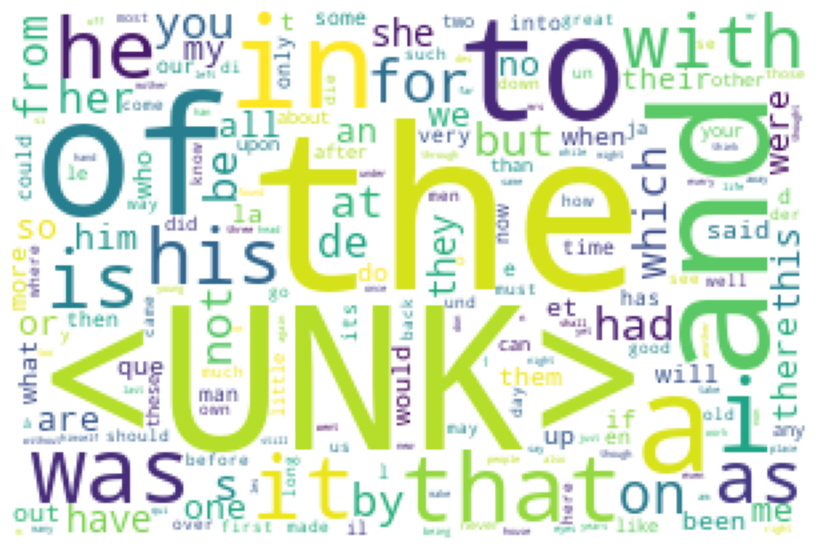

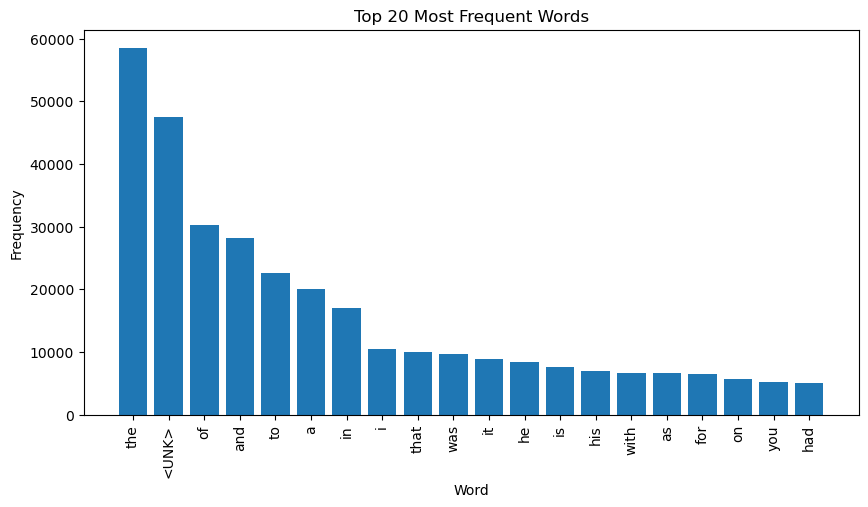

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the word frequencies from the word_to_index dictionary
word_frequencies = corpus.word_counts

# Create a WordCloud object with the word frequencies
wordcloud = WordCloud(width=300, height=200, background_color='white').generate_from_frequencies(word_frequencies)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Get the top 20 most frequent words
most_common_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
labels, values = zip(*most_common_words)

# Create a bar plot of the top 20 most frequent words
plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [10]:
import json
import pickle
import torch
import numpy as np
from Corpus import Corpus
from transformers import AutoTokenizer, AutoModel

# Load the configuration file
with open('config.json', 'r') as f:
    config = json.load(f)

# Load the Corpus object from the saved file
with open('corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

# Load a pre-trained transformer model and tokenizer
model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Get the word embeddings for all words in the corpus
embeddings = {}
for word in corpus.word_to_index.keys():
    # Tokenize the word and convert to input IDs
    input_ids = tokenizer.encode(word, add_special_tokens=True, return_tensors="pt")

    # Get the embedding for the input IDs
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings[word] = outputs[0][0][1:-1].numpy()

# The embeddings dictionary now contains the embeddings for all words in the corpus

# need todo perform various analyses on the embeddings, such as visualization, clustering, or similarity comparisons


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
#
# # Convert embeddings dictionary to a matrix
# embedding_matrix = np.array(list(embeddings.values()))
#
# # Convert data type to float
# embedding_matrix = embedding_matrix.astype(np.float32)
#
# # Replace NaN and inf values with a suitable value
# embedding_matrix[np.isnan(embedding_matrix)] = np.mean(embedding_matrix[~np.isnan(embedding_matrix)])
# embedding_matrix[np.isinf(embedding_matrix)] = 1e10
#
# # Perform PCA to reduce the dimensionality of the embeddings
# pca = PCA(n_components=2)
# pca_embeddings = pca.fit_transform(embedding_matrix)
#
# # Perform t-SNE to further reduce the dimensionality and project onto a 2D space
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embeddings = tsne.fit_transform(embedding_matrix)
#
# # Plot the embeddings using matplotlib
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].scatter(pca_embeddings[:, 0], pca_embeddings[:, 1])
# ax[0].set_title("PCA")
# ax[1].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])
# ax[1].set_title("t-SNE")
# plt.show()


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load a pre-trained transformer model and tokenizer
model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Get the word embeddings for all words in the corpus
embeddings = {}
for word in corpus.word_to_index.keys():
    # Tokenize the word and convert to input IDs
    input_ids = tokenizer.encode(word, add_special_tokens=True, return_tensors="pt")

    # Get the embedding for the input IDs
    with torch.no_grad():
        outputs = model(input_ids)
        if outputs[0].shape[1] == 0:
            embeddings[word] = np.zeros(768) # Assign zero vector if output tensor is empty
        else:
            embeddings[word] = outputs[0][0][1:-1].numpy()

# Convert embeddings dictionary to a matrix
embedding_matrix = np.array(list(embeddings.values()))

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embedding_matrix)

# Perform t-SNE to further reduce the dimensionality and project onto a 2D space
tsne = TSNE(n_components=2, random_state=0)
tsne_embeddings = tsne.fit_transform(embedding_matrix)

# Plot the embeddings using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(pca_embeddings[:, 0], pca_embeddings[:, 1])
ax[0].set_title("PCA")
ax[1].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])
ax[1].set_title("t-SNE")
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Perform k-means clustering on the embeddings
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding_matrix)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Print the words in each cluster
for i in range(n_clusters):
    cluster_words = [word for word, idx in embeddings.items() if labels[idx] == i]
    print(f"Cluster {i+1}: {', '.join(cluster_words)}")


In [ ]:
from scipy.spatial.distance import cosine

# Compute the cosine similarity between two words
word1 = "car"
word2 = "vehicle"
similarity = 1 - cosine(embeddings[word1], embeddings[word2])
print(f"Similarity between '{word1}' and '{word2}': {similarity:.3f}")


In [11]:
# import os
# import json
# import pickle
# from Corpus import Corpus
# from transformers import AutoTokenizer, AutoModel
# import numpy as np
#
# # Load the configuration file
# with open('config.json', 'r') as f:
#     config = json.load(f)
#
# # Load the Corpus object from the saved file
# with open('corpus.pkl', 'rb') as f:
#     corpus = pickle.load(f)
#
# # Load a pre-trained tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModel.from_pretrained("bert-base-uncased")
#
# # Convert the corpus into a list of strings
# corpus_text = [' '.join([corpus.index_to_word[str(idx)] for idx in seq]) for seq in corpus.full_token_sequence_as_ids]
#
# # Tokenize the corpus
# tokenized_corpus = [tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt') for text in corpus_text]
#
# # Generate embeddings for the corpus
# corpus_embeddings = []
# with torch.no_grad():
#     for batch in tokenized_corpus:
#         output = model(**batch)
#         embeddings = output.last_hidden_state[:, 0, :]
#         corpus_embeddings.append(embeddings.numpy())
#
# # Stack the embeddings into a single numpy array
# corpus_embeddings = np.vstack(corpus_embeddings)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: 'int' object is not iterable

In [5]:
# from transformers import AutoTokenizer, AutoModel
#
# # Load a pre-trained tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModel.from_pretrained("bert-base-uncased")
#
# # Convert the corpus into a list of strings
# corpus_text = [' '.join([corpus.index_to_word[idx] for idx in seq]) for seq in corpus.full_token_sequence_as_ids]
#
# # Tokenize the corpus
# tokenized_corpus = [tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt') for text in corpus_text]
#
# # Generate embeddings for the corpus
# corpus_embeddings = []
# with torch.no_grad():
#     for batch in tokenized_corpus:
#         output = model(**batch)
#         embeddings = output.last_hidden_state[:, 0, :]
#         corpus_embeddings.append(embeddings.numpy())
#
# # Stack the embeddings into a single numpy array
# corpus_embeddings = np.vstack(corpus_embeddings)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AttributeError: Can't get attribute 'Corpus' on <module '__main__'>

In [18]:

# Load the Word2Vec model
model = Word2Vec(len(corpus.word_to_index), 50)  # 50 is the embedding size used in the model
model.load_state_dict(torch.load('path/to/word2vec/model.pth'))  # Load the saved model parameters

# Set the model to evaluation mode
model.eval()

# Create an empty dictionary to hold the embeddings
embeddings = {}

# Loop through the words in the corpus and obtain their embeddings
for word, index in corpus.word_to_index.items():
    # Convert the word index to a tensor
    target_word_id = torch.tensor([index])

    # Pass the index tensor to the model's forward method to obtain the embedding vector
    embedding = model.target_embeddings(target_word_id)

    # Save the embedding vector to the dictionary
    embeddings[word] = embedding.detach().numpy()[0]

# The embeddings dictionary now contains the embeddings for all words in the corpus
# You can perform various analyses on the embeddings, such as visualization, clustering, or similarity comparisons


TypeError: Both corpus_file and corpus_iterable must not be provided at the same time

In [3]:
import pickle
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os
import json
from Corpus import Corpus
from transformers import AutoTokenizer, AutoModel
import numpy as np

# Load the configuration file
with open('config.json', 'r') as f:
    config = json.load(f)

# Load the Corpus object from the saved file
with open('corpus.pkl', 'rb') as f:
    corpus_data= pickle.load(f)


# Preprocess the text data
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
input_ids = tokenizer.encode(corpus_data.full_text)

# Set up the model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Generate text using the model
generated_text = model.generate(
    input_ids=input_ids,
    max_length=100,
    num_beams=5,
    temperature=0.7,
    repetition_penalty=2.0,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    early_stopping=True
)

# Print the generated text
print(tokenizer.decode(generated_text[0], skip_special_tokens=True))


AttributeError: 'Corpus' object has no attribute 'full_text'

In [5]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Load the CSV file
df = pd.read_csv('/Users/jeffereyreng/Desktop/SI_699/final_project/data/data_w_subj.csv')

# Preprocess the text data
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text_lines = df['text_lines'].tolist()
input_ids = []
for line in text_lines:
    encoded_line = tokenizer.encode(line, add_special_tokens=True, truncation=True)
    input_ids.extend(encoded_line)

# Split the data into training and validation sets
train_input_ids = input_ids[:len(input_ids) // 2]
val_input_ids = input_ids[len(input_ids) // 2:]

# Set up the dataset and data collator
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='',
    block_size=128,
    line_by_line=True,
    input_files=train_input_ids
)
val_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='',
    block_size=128,
    line_by_line=True,
    input_files=val_input_ids
)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./output',
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    save_steps=5000,
    save_total_limit=2,
    prediction_loss_only=True,
)

# Set up the trainer and model
model = GPT2LMHeadModel.from_pretrained('gpt2')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    prediction_loss_only=True
)

# Train the model
trainer.train()

# Generate text using the model
generated_text = model.generate(
    input_ids=tokenizer.encode("The quick brown fox jumps over the lazy dog"),
    max_length=100,
    num_beams=5,
    temperature=0.7,
    repetition_penalty=2.0,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    early_stopping=True
)

# Print the generated text
print(tokenizer.decode(generated_text[0], skip_special_tokens=True))


ValueError: Input 3693 is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

In [12]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Define a custom dataset class
class TextLineDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, input_lines, block_size):
        # Tokenize the input lines
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.examples = []
        for line in input_lines:
            tokens = self.tokenizer.encode(line.strip(), add_special_tokens=True, truncation=True, max_length=self.block_size)
            if len(tokens) > 0:
                self.examples.append(tokens)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        item = self.examples[idx]
        return torch.tensor(item)

# Load the CSV file
df = pd.read_csv('/Users/jeffereyreng/Desktop/SI_699/final_project/data/data_w_subj.csv')

# Preprocess the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_lines = df['text'].tolist()

# Set up the dataset and data collator
dataset = TextLineDataset(tokenizer, text_lines, block_size=128)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./output',
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    save_steps=5000,
    save_total_limit=2,
)

# Set up the trainer and model
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

# Train the model
trainer.train()

# Generate text using the model
generated_text = model.generate(
    input_ids=tokenizer.encode("The quick brown fox jumps over the lazy dog", add_special_tokens=True, truncation=True),
    max_length=100,
    num_beams=5,
    temperature=0.7,
    repetition_penalty=2.0,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    early_stopping=True
)

# Print the generated text
print(tokenizer.decode(generated_text[0], skip_special_tokens=True))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/homebrew/anaconda3/envs/workspace2/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


AttributeError: 'list' object has no attribute 'shape'